<a href="https://colab.research.google.com/github/gibi177/CIS--PS/blob/main/Modulo%201/Atividade%20Regressao/Atividade_Regressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade de Regressão

## Felipe Gibin

### 1. Análise inicial dos dados

O objetivo dessa atividade é utilizar regressão para classificar, em termos de qualidade, a variante vermelha do vinho verde brasileiro com base em suas características físicas e químicas.

#### 1.1 Carrega o dataset

In [138]:
import pandas as pd

#Carregar o dataset, que usa ; como delimitador
df = pd.read_csv('winequality-red.csv', delimiter=';')

#Visualizar primeiras linhas
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### 1.2 Trata valores faltantes

In [139]:
#Soma os valores zero e NaN por coluna
total = (df == 0).sum() + df.isna().sum()

# Mostrar resultado
print("Contagem de zeros + NaN por coluna:")
print(total)

Contagem de zeros + NaN por coluna:
fixed acidity             0
volatile acidity          0
citric acid             132
residual sugar            0
chlorides                 0
free sulfur dioxide       0
total sulfur dioxide      0
density                   0
pH                        0
sulphates                 0
alcohol                   0
quality                   0
dtype: int64


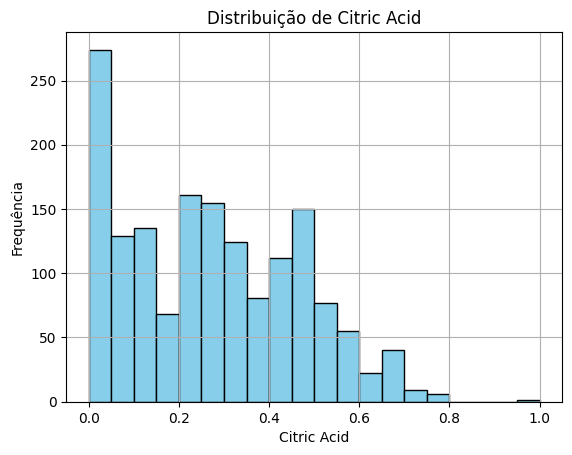

In [140]:
import matplotlib.pyplot as plt

# Criar um histograma para a coluna 'citric acid'
df['citric acid'].hist(bins=20, color='skyblue', edgecolor='black')

# Adicionar título e rótulos aos eixos
plt.title('Distribuição de Citric Acid')
plt.xlabel('Citric Acid')
plt.ylabel('Frequência')

# Mostrar o gráfico
plt.show()

Observamos que somente a coluna de ácido cítrico possui valores faltantes. Considerando-os como valores do tipo MCAR (Missing Completely At Random), vamos substituí-los pela mediana dessa coluna, visto que a distribuição de ácido cítrico não é simétrica.

In [141]:
# Substitui zero pela mediana
df = df.apply(lambda x: x.replace(0, x.median()))

# Substitui NaN pela mediana
df.fillna(df.median(), inplace=True)

# Verificar a contagem de zeros e NaN novamente
total = (df == 0).sum() + df.isna().sum()

# Mostrar o resultado
print("Contagem de zeros + NaN por coluna após a substituição:")
print(total)

Contagem de zeros + NaN por coluna após a substituição:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


#### 1.3 Trata outliers

Para tratar os outliers do conjunto de dados, vamos limitar os valores aos percentis 5% e 95%. Os valores que sofrerem o capping serão ajustados para o valor do percentil correspondente (5% ou 95%), de forma a evitar que afetem a analise sem excluir completamente sua influência.

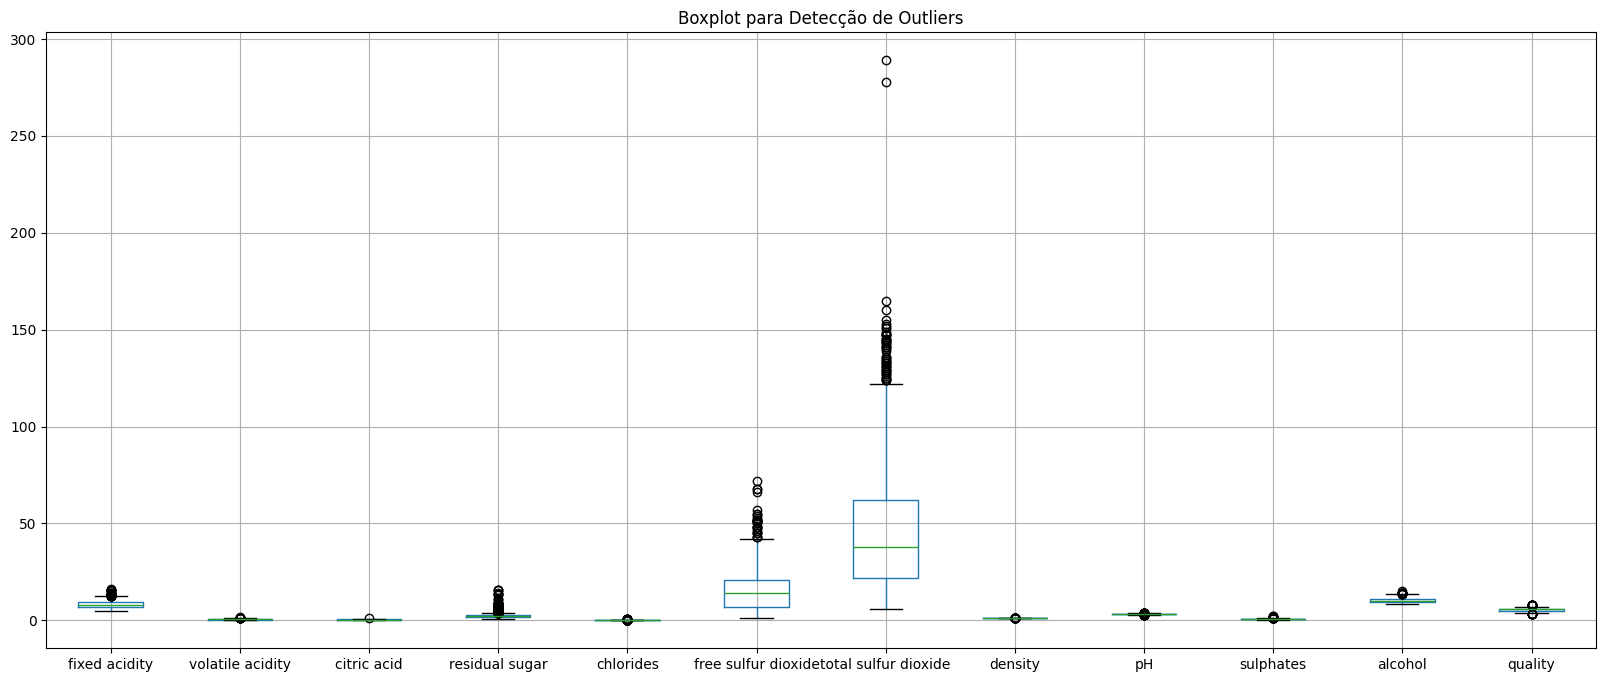

In [142]:
# Boxplot geral para identificação de outliers
plt.figure(figsize=(20, 8))
df.boxplot()
plt.title("Boxplot para Detecção de Outliers")
plt.show()

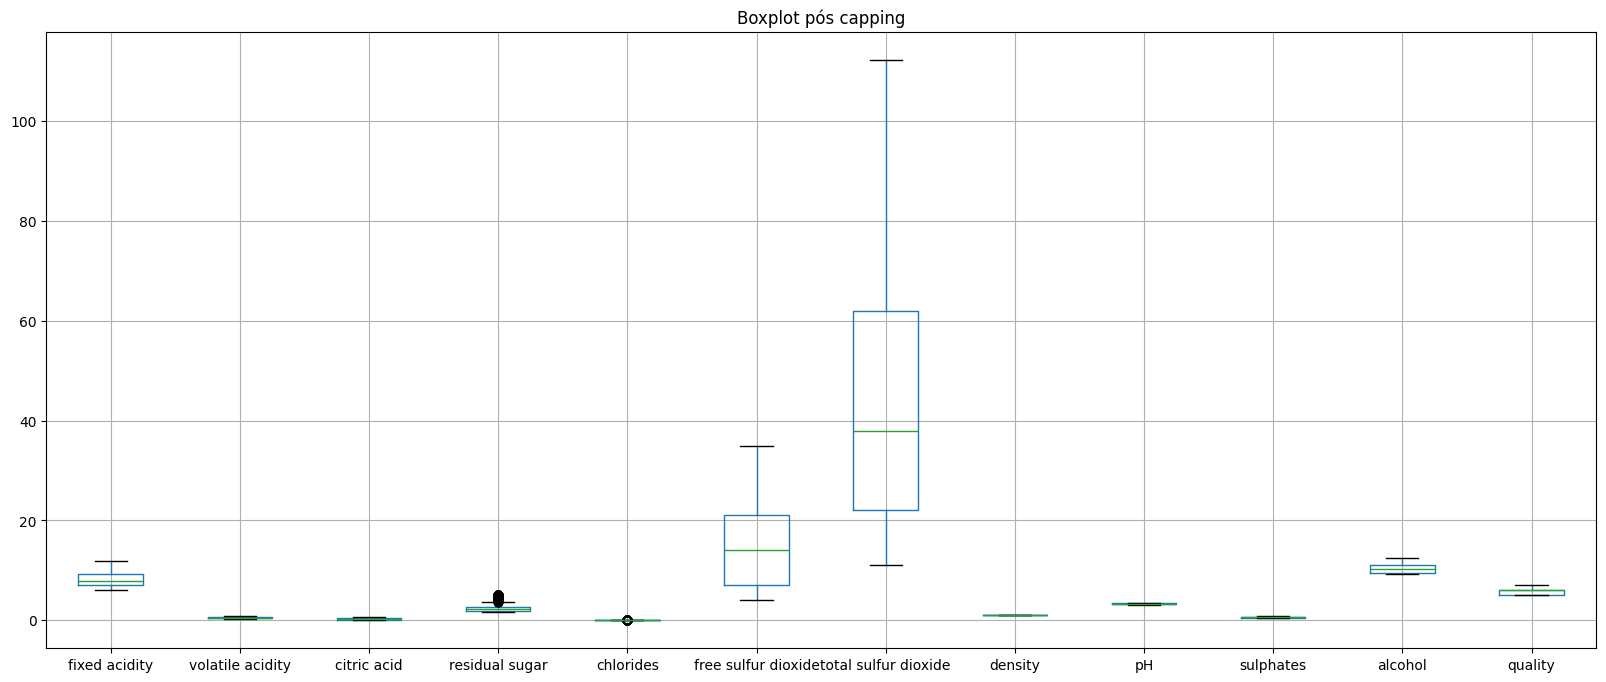

In [143]:
import numpy as np

#funcao de capping (5-95%)
def cap_outliers(data, column):
    lower = data[column].quantile(0.05)
    upper = data[column].quantile(0.95)
    data[column] = np.clip(data[column], lower, upper)

for col in df:
    cap_outliers(df, col)

#Novo boxplot, apos o capping
plt.figure(figsize=(20, 8))
df.boxplot()
plt.title("Boxplot pós capping")
plt.show()

#### 1.4 Próximos passos

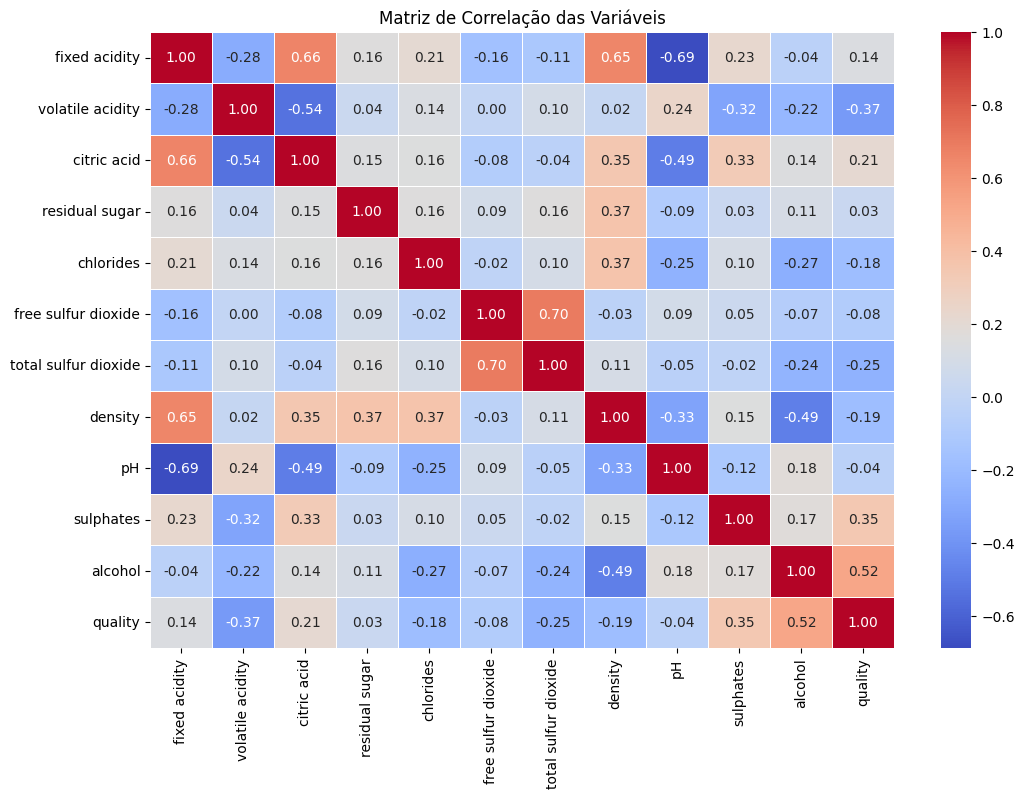

In [144]:
import seaborn as sns

#Matriz de correlação
correlation_matrix = df.corr()

# Visualização
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação das Variáveis')
plt.show()

Após a remoção de outliers e substituição de valores faltantes, nos resta criar o modelo em si, baseado em regressão. Nosso problema possui um número grande de parâmetros, o que pode dificultar o treinamento. No cenário observado em que nossas variáveis independentes estão fortememente correlacionadas, é interessante usar a técnica de Ridge regression (forma de regularização da regressão linear), que mitiga o problema de multicolinearidade e penaliza o tamanho dos coeficientes, o que ajuda a evitar o overfitting.

### 2. Definição e treinamento do modelo

In [145]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Definir as variáveis independentes (X) e a variável dependente (y)
X = df.drop('quality', axis=1)
y = df['quality']

# Divisçao do conjunto de dados (20% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Modelo
ridge_model = Ridge(alpha=1.0)

#Treinamento
ridge_model.fit(X_train,y_train)

#Previsões do conjunto de testes
y_pred = ridge_model.predict(X_test)

### 3. Avaliação

Avaliaremos o desempenho do modelo usando o MAE (mean absolute error), MSE (mean squarred error) e o índice R² (coeficiente de determinação), que explica o modelo é capaz de explicar a variabilidade dos dados.

#### 3.1 Métricas de avaliação

In [146]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Erro Quadrático Médio: {mse}")
print(f"Erro Absoluto Médio: {mae}")
print(f"R²: {r2}")

Erro Quadrático Médio: 0.2950698997463802
Erro Absoluto Médio: 0.45048254727165793
R²: 0.4112859922447718


#### 3.2 Gráficos

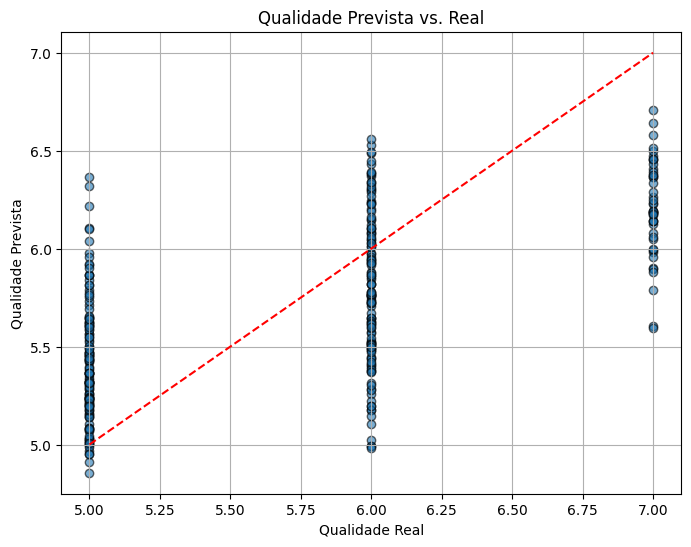

In [147]:
#Gráfico de dispersão: valores reais vs. previstos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Qualidade Real')
plt.ylabel('Qualidade Prevista')
plt.title('Qualidade Prevista vs. Real')
plt.grid(True)
plt.show()

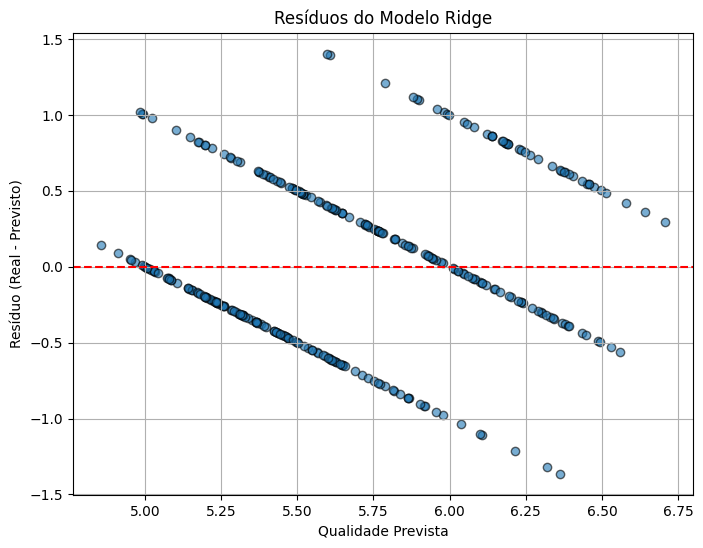

In [148]:
#Gráfico de resíduos
residuos = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuos, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Qualidade Prevista')
plt.ylabel('Resíduo (Real - Previsto)')
plt.title('Resíduos do Modelo Ridge')
plt.grid(True)
plt.show()


Ao analisar os resultados, observamos que estes se encontram dentro da faixa esperada para o problema proposto. Prever a qualidade de um vinho é, como a palavra indica, um problema qualitativo, em que propriedades fisico-quimicas não conseguem capturar a dependência subjetiva da variável dependente (quality). Tanto o MSE quanto o MAE indicam que a previsão do nosso modelo não ficou muito longe do valor real de qualidade. Ademais, um R² de 0.41, embora aparentemente baixo, está em uma faixa aceitável, visto que esse índice não captura a complexidade do modelo, ou mesmo o fator subjetivo mencionado. Além disso, outro fator que dificulta a predição é que o problema analisado não é linearmente separável, logo a regressão linear nunca será totalmente satisfatória para resolvê-lo. Uma sugestão de melhora seria usar MLPs para a predição, a fim de capturar a relação não linear do problema.